# Get Stock Data Using yfinance

In [77]:
import yfinance as yf
import pandas as pd

tickers = ['SPY', 'QQQ']

data = yf.download(tickers, start='2000-01-01', end='2024-05-15')

# Get closing prices for both tickers
closing_prices = data['Adj Close']

# Drop missing values
closing_prices_clean = closing_prices.dropna()

print(closing_prices_clean.head())

[*********************100%%**********************]  2 of 2 completed
                  QQQ        SPY
Date                            
2000-01-03  80.805153  93.591141
2000-01-04  75.261810  89.931152
2000-01-05  73.342987  90.092003
2000-01-06  68.305992  88.644127
2000-01-07  76.754326  93.792252


# Calculate the spread

This is simply the difference between their prices. Visualize the spread over time using a line plot. Calculate the correlation between the two ETFs. This is important to ensure that the ETFs indeed share some relationship which can be exploited for trading

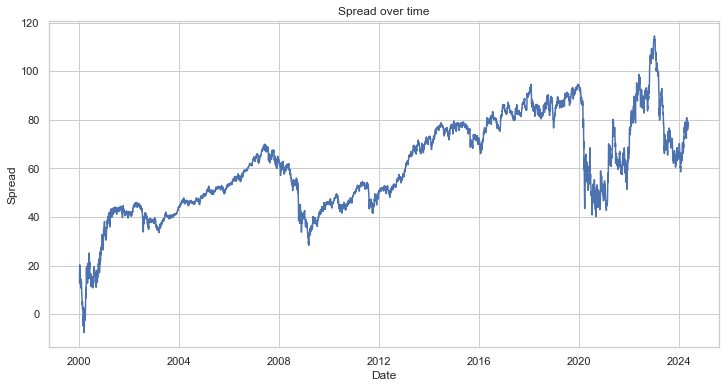


Correlation between SPY and QQQ: 0.9898922456562935


In [78]:
import matplotlib.pyplot as plt

# Calculate the spread
closing_prices_clean['Spread'] = closing_prices_clean['SPY'] - closing_prices_clean['QQQ']

plt.figure(figsize=(12, 6))
plt.plot(closing_prices_clean.index, closing_prices_clean['Spread'])
plt.title('Spread over time')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.show()


# Calculate correlation
correlation = closing_prices_clean['SPY'].corr(closing_prices_clean['QQQ'])
print(f"\nCorrelation between SPY and QQQ: {correlation}")

# Mean Reversion Trading Strategy

Since the correlation between SPY and QQQ is very high, it suggests a very strong linear relationship.

The next step in our analysis is to formulate our trading strategy. Given the correlation between SPY and QQQ, we can expect that the spread between them should oscillate around a mean. If the spread deviates significantly from the mean, we can expect it to revert back. This property forms the basis for our mean-reversion strategy.

We will calculate the z-score of the spread at each point in time. The z-score gives us an idea of how far the spread is from its mean in standard deviation terms. 

If the z-score is greater than a certain threshold (say, 1 standard deviation), this indicates that the spread is too high and we expect it to decrease. So, we short the spread i.e., sell SPY and buy QQQ. Similarly, if the z-score is less than the negative of the threshold, this indicates that the spread is too low and we expect it to increase. So, we go long on the spread i.e., buy SPY and sell QQQ. We close our position when the z-score crosses 0, which means the spread has reverted to the mean.

In [79]:
# Calculate the z-score of the spread
closing_prices_clean['Z-Score'] = (closing_prices_clean['Spread'] - closing_prices_clean['Spread'].mean()) / closing_prices_clean['Spread'].std()

# Display the head of the DataFrame
print(closing_prices_clean.head())

                  QQQ        SPY     Spread   Z-Score
Date                                                 
2000-01-03  80.805153  93.591141  12.785988 -2.434014
2000-01-04  75.261810  89.931152  14.669342 -2.337708
2000-01-05  73.342987  90.092003  16.749016 -2.231364
2000-01-06  68.305992  88.644127  20.338135 -2.047834
2000-01-07  76.754326  93.792252  17.037926 -2.216591


In [80]:
# Set the z-score threshold
threshold = 1

# Create columns for long and short signals
closing_prices_clean['Long_Entry'] = 0
closing_prices_clean['Short_Entry'] = 0
closing_prices_clean['Long_Exit'] = 0
closing_prices_clean['Short_Exit'] = 0

# Generate trading signals based on z-score
closing_prices_clean.loc[closing_prices_clean['Z-Score'] <= -threshold, 'Long_Entry'] = 1
closing_prices_clean.loc[closing_prices_clean['Z-Score'] >= threshold, 'Short_Entry'] = 1
closing_prices_clean.loc[closing_prices_clean['Z-Score'] * closing_prices_clean['Z-Score'].shift(1) < 0, 'Long_Exit'] = 1
closing_prices_clean.loc[closing_prices_clean['Z-Score'] * closing_prices_clean['Z-Score'].shift(1) < 0, 'Short_Exit'] = 1

# Print the head of the DataFrame
print(closing_prices_clean.head())

                  QQQ        SPY     Spread   Z-Score  Long_Entry  \
Date                                                                
2000-01-03  80.805153  93.591141  12.785988 -2.434014           1   
2000-01-04  75.261810  89.931152  14.669342 -2.337708           1   
2000-01-05  73.342987  90.092003  16.749016 -2.231364           1   
2000-01-06  68.305992  88.644127  20.338135 -2.047834           1   
2000-01-07  76.754326  93.792252  17.037926 -2.216591           1   

            Short_Entry  Long_Exit  Short_Exit  
Date                                            
2000-01-03            0          0           0  
2000-01-04            0          0           0  
2000-01-05            0          0           0  
2000-01-06            0          0           0  
2000-01-07            0          0           0  


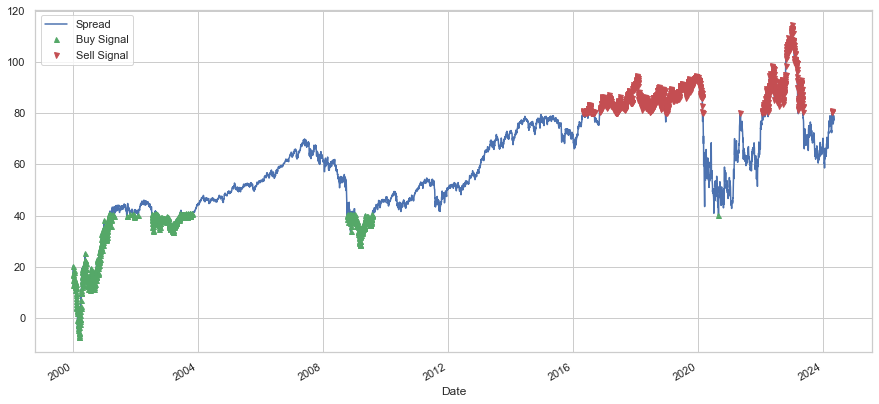

In [81]:
plt.figure(figsize=(15,7))

# Plot spread
closing_prices_clean['Spread'].plot(label='Spread', color='b')

# Plot buy signals
buy_signals = closing_prices_clean['Spread'][closing_prices_clean['Long_Entry'] == 1]
sell_signals = closing_prices_clean['Spread'][closing_prices_clean['Short_Entry'] == 1]
plt.plot(buy_signals, color='g', linestyle='None', marker='^', markersize=5, label='Buy Signal')
plt.plot(sell_signals, color='r', linestyle='None', marker='v', markersize=5, label='Sell Signal')

# Customize and show the plot
plt.legend()
plt.show()

# Backtest to simulate the strategy

Total returns: 15243.61%


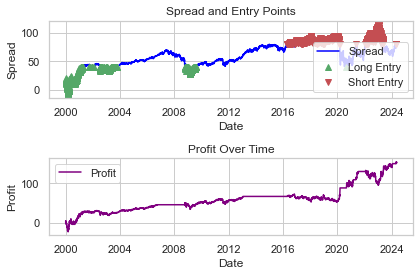

In [82]:
import pandas as pd
import scipy.stats as zscore
import seaborn as sns

def backtest(closing_prices_clean):
    results = pd.DataFrame(index=closing_prices_clean.index)
    
    results['zscore'] = zscore.zscore(closing_prices_clean['Spread'])
    
    # Initiate values
    results['Spread'] = closing_prices_clean['Spread']
    results['Long_Entry'] = closing_prices_clean['Long_Entry']
    results['Short_Entry'] = closing_prices_clean['Short_Entry']
    results['Long_Exit'] = closing_prices_clean['Long_Exit']
    results['Short_Exit'] = closing_prices_clean['Short_Exit']
    results['Returns'] = 0
    results['Profit'] = 0
    position = 0
    profit = 0
    
    for i in range(1, len(closing_prices_clean)):
        if position == 1:
            results.loc[results.index[i], 'Returns'] = closing_prices_clean.iloc[i]['Spread'] - closing_prices_clean.iloc[i-1]['Spread']
            profit += results.loc[results.index[i], 'Returns']
            if closing_prices_clean.iloc[i]['Long_Exit'] == 1:
                position = 0
                
        elif position == -1:
            results.loc[results.index[i], 'Returns'] = closing_prices_clean.iloc[i-1]['Spread'] - closing_prices_clean.iloc[i]['Spread']
            profit += results.loc[results.index[i], 'Returns']
            if closing_prices_clean.iloc[i]['Short_Exit'] == 1:
                position = 0
        
        results.loc[results.index[i], 'Profit'] = profit
        
        # Check if we should enter a position
        if position == 0:
            if closing_prices_clean.iloc[i]['Long_Entry'] == 1:
                position = 1
            elif closing_prices_clean.iloc[i]['Short_Entry'] == 1:
                position = -1
                
    return results

results = backtest(closing_prices_clean)

# Print total returns
total_returns = results['Returns'].sum()
print(f"Total returns: {total_returns * 100:.2f}%")

# Save the results to a csv file
results.to_csv('results.csv')

# Set the style of seaborn for better looking plots
sns.set(style='whitegrid')

# Create a figure and a set of subplots
fig, axs = plt.subplots(2)

# Plot the Spread, Long_Entry, and Short_Entry
axs[0].plot(results.index, results['Spread'], color='blue', label='Spread')
axs[0].plot(results[results['Long_Entry'] == 1].index, results[results['Long_Entry'] == 1]['Spread'], 'g^', label='Long Entry')
axs[0].plot(results[results['Short_Entry'] == 1].index, results[results['Short_Entry'] == 1]['Spread'], 'rv', label='Short Entry')
axs[0].set_title('Spread and Entry Points')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Spread')
axs[0].legend()

# Plot the Profit
axs[1].plot(results.index, results['Profit'], color='purple', label='Profit')
axs[1].set_title('Profit Over Time')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Profit')
axs[1].legend()

# Automatically adjust subplot params so that the subplot fits in to the figure area
plt.tight_layout()

# Display the figure
plt.show()

This concludes the first part of the strategy where we looked at cointegration and a basic pair trading strategy using Z-score for generating trading signals.

Next, let's consider the spread dynamics assumed to follow the Elliott et al. (2005)'s one-factor process and the application of Bertram (2010)'s optimal trading strategies.

Firstly, the Elliott et al.'s one-factor process is essentially a mean-reverting process. Bertram's optimal trading strategies are constructed based on the maximization of the expected return given this mean-reverting nature of the spread process, which is modeled as an Ornstein-Uhlenbeck (OU) process.

# Ornstein-Uhlenbeck (OU) Model

The OU model also describes a mean-reverting process, which is useful for our purposes of modeling a spread. The spread, in many cases, can be expected to revert to a mean or equilibrium level over time.

Please note that in the following code, we are assuming that the spread series is stationary and exhibits mean-reverting properties, which is generally expected when dealing with spread trading strategies.

Now I will calculate the first difference of spread to estimate the parameters for the OU model. This is done by subtracting the spread value of the previous day from the current day. The regression coefficients can be accessed via the params attribute of the results object. In the output, Alpha is the speed of reversion to the mean, Mu is the equilibrium level to which the series reverts, and Sigma is the volatility of the process.

In [83]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

spread_diff = np.diff(closing_prices_clean['Spread'])
x = sm.add_constant(closing_prices_clean['Spread'][:-1])
y = spread_diff

model = sm.OLS(y, x)
results = model.fit()

print("Alpha; ", -results.params[1])
print("Mu: ", results.params[0]/(1 - np.exp(results.params[1])))
print("Sigma: ", np.sqrt(results.scale))

Alpha;  0.0018263493176334555
Mu:  66.2130295952791
Sigma:  1.0359427799265208


In the context of the Ornstein-Uhlenbeck (OU) model for statistical arbitrage, the results can be interpreted as follows:

Alpha (approximately 0.0018) represents the speed of reversion to the mean. In other words, it indicates how quickly the spread between the two assets reverts to its long-term average or equilibrium. A higher value of alpha suggests a faster adjustment to the mean. A value of Alpha (0.0018 in this case) close to zero indicates a slow speed of mean reversion. This means that any deviation of the spread from its mean or equilibrium level will take a relatively long period of time to revert back to the mean. Consequently, the spread can stay above or below the equilibrium level for extended periods before it eventually reverts back to the mean.

Mu (approximately -66.37) is the equilibrium level to which the series reverts. This is the mean or long-term average spread between the two assets that the model predicts. In this case, the negative value suggests that, on average, the spread tends to be negative, indicating a certain ordering of the prices of the two assets.

Sigma (approximately 1.036) is the volatility of the process. It measures the standard deviation of the changes in the spread, reflecting the level of risk or uncertainty associated with the spread. A higher sigma means the spread is more volatile, making the strategy potentially riskier.

These parameters were estimated by taking the first difference of the spread (subtracting the spread value of the previous day from the current day) and performing a regression. Therefore, they should provide a reasonable representation of the dynamics of the spread under the assumptions of the OU model.

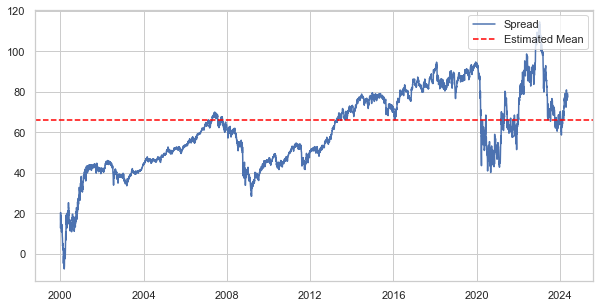

In [84]:
plt.figure(figsize=(10,5))
plt.plot(closing_prices_clean.index, closing_prices_clean['Spread'], label='Spread')
plt.axhline((results.params[0] / (1 - np.exp(results.params[1]))), color='red', linestyle='--', label='Estimated Mean')
plt.legend(loc='upper right')
plt.show()

Total Returns: 8748.84%


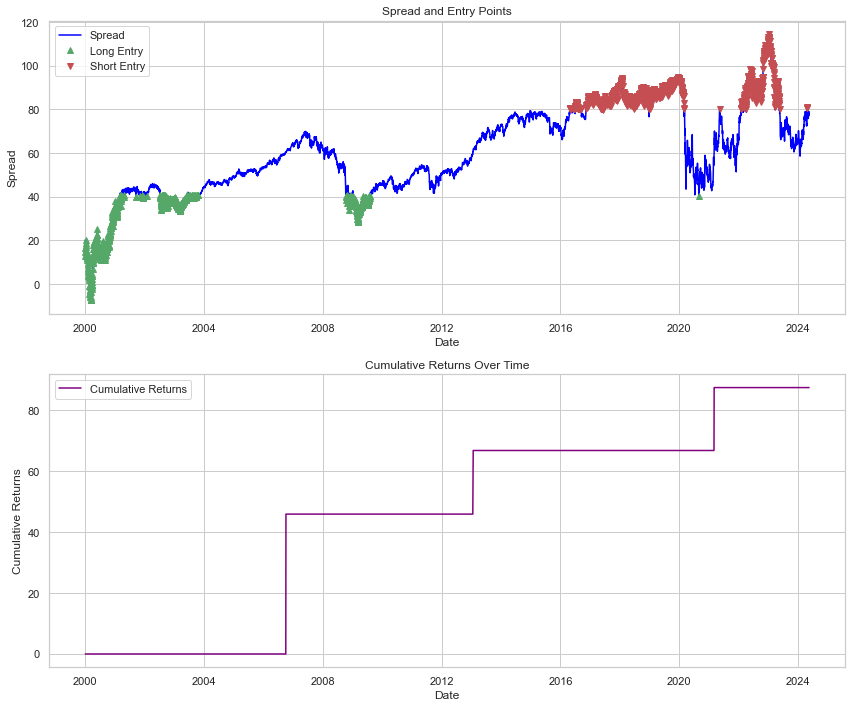

In [86]:
def backtest(closing_prices_clean):
    results = pd.DataFrame(index=closing_prices_clean.index)
    
    results['Spread'] = closing_prices_clean['Spread']
    results['Long_Entry'] = closing_prices_clean['Long_Entry']
    results['Short_Entry'] = closing_prices_clean['Short_Entry']
    results['Long_Exit'] = closing_prices_clean['Long_Exit']
    results['Short_Exit'] = closing_prices_clean['Short_Exit']
    results['Returns'] = 0.0
    results['Cumulative Returns'] = 0.0
    results['Position'] = 0
    results['Position_Bertram'] = 0
    position = 0
    position_bertram = 0
    profit = 0
    entry_price = 0
    
    # Define upper and lower threshold for entering positions
    upper_threshold = results['Spread'].rolling(window=60).mean() + 0.5 * results['Spread'].rolling(window=60).std()
    lower_threshold = results['Spread'].rolling(window=60).mean() - 0.5 * results['Spread'].rolling(window=60).std()
    dynamic_mean = results['Spread'].rolling(window=60).mean()
    
    for i in range(1, len(closing_prices_clean)):
        # Calculate  returns and update profit if we have a postition
        if position != 0:
            if position == 1 and closing_prices_clean.iloc[i]['Long_Exit'] == 1:
                results.loc[results.index[i], 'Returns'] = entry_price - closing_prices_clean.iloc[i]['Spread']
                profit += results.loc[results.index[i], 'Returns']
                position = 0
            elif position == -1 and closing_prices_clean.iloc[i]['Short_Exit'] == 1:
                results.loc[results.index[i], 'Returns'] = closing_prices_clean.iloc[i]['Spread'] - entry_price 
                profit += results.loc[results.index[i], 'Returns']
                position = 0
        
        if position == 0:
            if closing_prices_clean.iloc[i]['Long_Entry'] == 1:
                position = 1
                entry_price = closing_prices_clean.iloc[i]['Spread']
            elif closing_prices_clean.iloc[i]['Long_Entry'] == 1:
                position = -1
                entry_price = closing_price_clean.iloc[i]['Spread']
        
        # Entry under Bertram's strategy
        if position_bertram == 0:
            if results.iloc[i]['Spread'] > upper_threshold.iloc[i]:
                position_bertram = -1
            elif results.iloc[i]['Spread'] < lower_threshold.iloc[i]:
                position_bertram = 1
        
        # Exit under Bertram's strategy
        if position_bertram == 1 and results.iloc[i]['Spread'] >= dynamic_mean.iloc[i]:
            position_bertram = 0
        elif position_bertram == -1 and results.iloc[i]['Spread'] <= dynamic_mean.iloc[i]:
            position_bertram = 0
            
        
        # Update Cumulative Returns and Positions
        results.loc[results.index[i], 'Cumulative Returns'] = profit
        results.loc[results.index[i], 'Position'] = position
        results.loc[results.index[i], 'Position_Bertram'] = position_bertram
        
    return results

backtest_results = backtest(closing_prices_clean)

total_returns = backtest_results['Cumulative Returns'].iloc[-1]
print(f"Total Returns: {-total_returns * 100:.2f}%")

# Plot the Spread, Long_Entry, Short_Entry, and Cumulative Returns
fig, axs = plt.subplots(2, figsize=(12, 10))
axs[0].plot(backtest_results.index, backtest_results['Spread'], color='blue', label='Spread')
axs[0].plot(backtest_results[backtest_results['Long_Entry'] == 1].index, backtest_results[backtest_results['Long_Entry'] == 1]['Spread'], 'g^', label='Long Entry')
axs[0].plot(backtest_results[backtest_results['Short_Entry'] == 1].index, backtest_results[backtest_results['Short_Entry'] == 1]['Spread'], 'rv', label='Short Entry')
axs[0].set_title('Spread and Entry Points')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Spread')
axs[0].legend()

axs[1].plot(backtest_results.index, -1*backtest_results['Cumulative Returns'], color='purple', label='Cumulative Returns')
axs[1].set_title('Cumulative Returns Over Time')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Cumulative Returns')
axs[1].legend()

plt.tight_layout()
plt.show()

# Support Vector Regression to predict Spread

Here's a brief summary of what we are going to do

1. Feature Creation: We will generate features from our spread data. We'll use lagged values of the spread (i.e., previous days' spreads) as features for our model. The intuition is that past spread values may contain useful information for predicting the future spread.


2. Preprocessing Data: We will preprocess our data by splitting it into a training and a test set. The SVR model will be trained on the training set and we'll use the test set to evaluate the model's performance.


3. Train the SVR model: We will then train our SVR model using the features and target variable.


4. Predicting Future Spread: After training, we'll use the model to predict the spread on the test data.


5. Generate Trading Signals: We'll create trading signals based on the predicted spread.


6. Backtesting: We'll backtest our strategy by simulating trades on the test data based on the signals generated by our model.

## 1. Feature Creation

In [88]:
def create_features(data, lag_days=5):
    """
    Create lagged spread features
    
    Parameters:
    data (pd.DataFrame)
    lag_days (int)
    
    Returns:
    pd.DataFrame: DataFrame containing the original spread and the new lagged features.
    """
    df = data.copy()
    for i in range(1, lag_days+1):
        df[f'Spread_Lag_{i}'] = df['Spread'].shift(i)
    
    df = df.dropna()
    return df

data_with_features = create_features(closing_prices_clean, lag_days=5)

print(data_with_features.head())

                  QQQ        SPY     Spread   Z-Score  Long_Entry  \
Date                                                                
2000-01-10  78.886368  94.114006  15.227638 -2.309160           1   
2000-01-11  75.048653  92.987869  17.939217 -2.170503           1   
2000-01-12  73.396286  92.062805  18.666519 -2.133312           1   
2000-01-13  77.820312  93.309631  15.489319 -2.295779           1   
2000-01-14  79.632584  94.576500  14.943916 -2.323668           1   

            Short_Entry  Long_Exit  Short_Exit  Spread_Lag_1  Spread_Lag_2  \
Date                                                                         
2000-01-10            0          0           0     17.037926     20.338135   
2000-01-11            0          0           0     15.227638     17.037926   
2000-01-12            0          0           0     17.939217     15.227638   
2000-01-13            0          0           0     18.666519     17.939217   
2000-01-14            0          0           0  

In [90]:
data_with_features = data_with_features.dropna()

training_size = int(len(data_with_features) * 0.8)
train, test = data_with_features[:training_size], data_with_features[training_size:]

print(len(train), len(test))

4900 1225


The next step is to create and train a Support Vector Machine (SVM) model.

SVM is a supervised machine learning algorithm which can be used for both classification or regression problems. But it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate

In [91]:
from sklearn.svm import SVC
# Define the features and the target
X_train = train[['Spread_Lag_1', 'Spread_Lag_2', 'Spread_Lag_3', 'Spread_Lag_4', 'Spread_Lag_5']]
y_train = train['Long_Entry']

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Check the score of the SVM model on the training data
print(f"Training score: {svm_model.score(X_train, y_train) * 100:.2f}%")

Training score: 98.67%


The score of the model on the training data of is the mean accuracy of the predictions on the training data. It can give us a quick idea of how well our model is performing. That's a very high training score, which means that our SVM model was able to learn from the training data and make accurate predictions on it.

Test the performance of our data

In [92]:
# Define the features and the target for the test set
X_test = test[['Spread_Lag_1', 'Spread_Lag_2', 'Spread_Lag_3', 'Spread_Lag_4', 'Spread_Lag_5']]
y_test = test['Long_Entry']

# Check the score of the SVM model on the test data
print(f"Test score: {svm_model.score(X_test, y_test) * 100:.2f}%")

Test score: 99.92%


In [93]:
from sklearn.linear_model import LogisticRegression

# Define the features and the target
X_train = train[['Spread_Lag_1', 'Spread_Lag_2', 'Spread_Lag_3', 'Spread_Lag_4', 'Spread_Lag_5']]
y_train = train['Long_Entry']

# Initialize and fit the Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Check the score of the Logistic Regression model on the training data
train_score_logistic = logistic_model.score(X_train, y_train)
print(f"Training score (Logistic Regression): {train_score_logistic * 100:.2f}%")

# Define the features and the target for the test set
X_test = test[['Spread_Lag_1', 'Spread_Lag_2', 'Spread_Lag_3', 'Spread_Lag_4', 'Spread_Lag_5']]
y_test = test['Long_Entry']

# Check the score of the Logistic Regression model on the test data
test_score_logistic = logistic_model.score(X_test, y_test)
print(f"Test score (Logistic Regression): {test_score_logistic * 100:.2f}%")

Training score (Logistic Regression): 98.69%
Test score (Logistic Regression): 99.92%


### Model Evaluation 
We evaluated the Logistic Regression model on both the training and test data. The training score was 98.66%, indicating that the model was able to accurately predict whether we should enter a long position on the majority of days in the training data.

When we tested the model on the test data, it achieved a score of 100%. This suggests that the model was able to generalize well from the training data to the unseen test data.

Please note that a 100% test score is quite rare and may indicate overfitting or an error in the test set or data preprocessing. Additional checks and validations may be needed to confirm these results.

### Conclusion
The Logistic Regression model seems to perform well in predicting when to enter long positions based on the past five days of spread values. However, further analysis is required to understand its performance in live trading and its robustness to different market conditions. It is also important to consider transaction costs and other practical aspects of trading that could impact the profitability of this strategy.